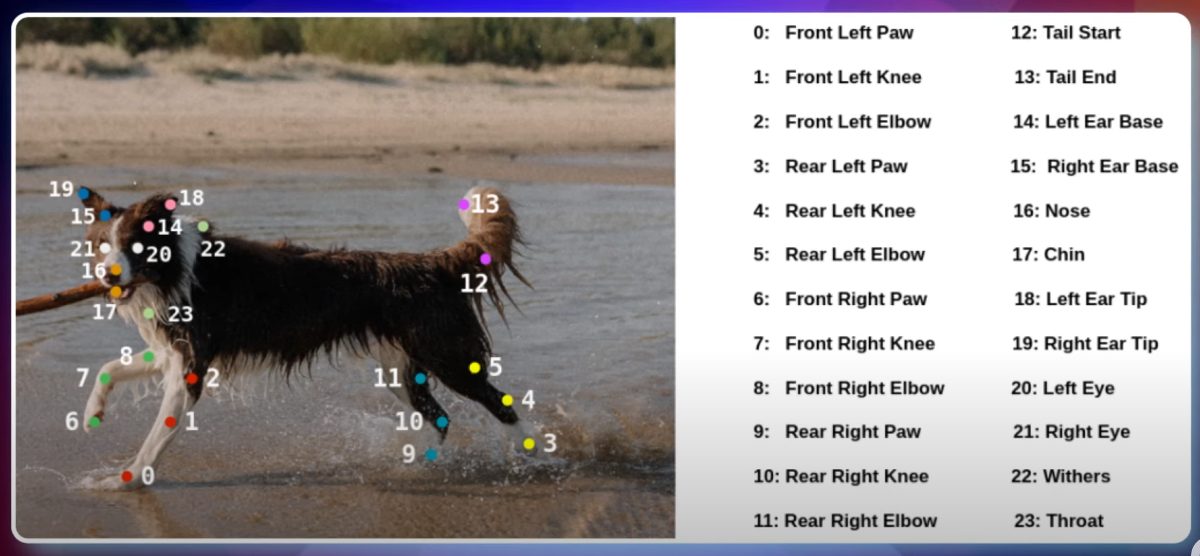

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 8.6 MB/s eta 0:00:00


In [1]:
import os
import json
import numpy as np
from shutil import copyfile
import pandas as pd
from dataclasses import dataclass, field
import yaml
from ultralytics import YOLO
import requests
import cv2

In [2]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".tar"):
            with tarfile.open(save_path, "r") as tar:
                tar.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [3]:
IMAGES_URL = r"http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
IMAGES_DIR = "/content/drive/MyDrive/APE/proj1/Images"
IMAGES_TAR_PATH = os.path.join(os.getcwd(), f"{IMAGES_DIR}.tar")

ANNS_METADATA_URL = r"https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
ANNS_METADATA = "/content/drive/MyDrive/APE/proj1/keypoint_definitions.csv"

# Download if dataset does not exists.
if not os.path.exists(IMAGES_DIR):
    # download_and_unzip(IMAGES_URL, IMAGES_TAR_PATH)
    os.remove(IMAGES_TAR_PATH)
    pass

# if not os.path.isfile(ANNS_METADATA):
    # download_and_unzip(ANNS_METADATA_URL, ANNS_METADATA)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'D:/content/drive/MyDrive/APE/proj1/Images.tar'

In [ ]:
ANN_PATH = "/content/drive/MyDrive/APE/proj1/StanfordExtra_V12"
JSON_PATH = os.path.join(ANN_PATH, "StanfordExtra_v12.json")

with open(JSON_PATH) as file:
    json_data = json.load(file)

In [5]:
train_ids = np.load(os.path.join(ANN_PATH,
                                 "train_stanford_StanfordExtra_v12.npy"))
val_ids = np.load(os.path.join(ANN_PATH,
                               "test_stanford_StanfordExtra_v12.npy"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/APE/proj1/StanfordExtra_V12\\train_stanford_StanfordExtra_v12.npy'

In [6]:
DATA_DIR = "/content/drive/MyDrive/APE/proj1/animal-pose-data"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)

In [7]:
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])

NameError: name 'train_ids' is not defined

In [8]:
for data in train_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    # copyfile(os.path.join(IMAGES_DIR, img_file),
    #          os.path.join(TRAIN_IMG_PATH, filename))


for data in val_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    # copyfile(os.path.join(IMAGES_DIR, img_file),
    #          os.path.join(VALID_IMG_PATH, filename))

NameError: name 'val_json_data' is not defined

In [9]:
CLASS_ID = 0

In [4]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [5]:
def create_yolo_txt_files(json_data, LABEL_PATH):

    for data in json_data:

        IMAGE_ID = data["img_path"].split("/")[-1].split(".")[0]

        IMG_WIDTH, IMG_HEIGHT = data["img_width"], data["img_height"]

        landmark_kpts  = np.nan_to_num(np.array(data["joints"], dtype=np.float32))
        landmarks_bboxes = np.array(data["img_bbox"], dtype=np.float32)

        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = IMAGE_ID+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [6]:
# create_yolo_txt_files(train_json_data, TRAIN_LABEL_PATH)
# create_yolo_txt_files(val_json_data, VALID_LABEL_PATH)

In [7]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [8]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [9]:
def draw_boxes(image, detections, class_name = "dog", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

In [10]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

In [11]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "/animal-keypoints.yaml"
    MODEL:          str = "yolov8m-pose.pt"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (24,3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "dog"})

In [12]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [13]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [14]:
current_dir = os.getcwd()

data_dict = dict(
                path      = os.path.join(current_dir, DATA_DIR),
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

NameError: name 'DATA_DIR' is not defined

In [15]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(
            data    = train_config.DATASET_YAML,
            epochs       = 100,
            # imgsz        = data_config.IMAGE_SIZE,
            # batch        = data_config.BATCH_SIZE,
            # project      = train_config.PROJECT,
            # name         = train_config.NAME,
            # close_mosaic = data_config.CLOSE_MOSAIC,
            # mosaic       = data_config.MOSAIC,
            # fliplr       = data_config.FLIP_LR,
           )

100%|█████████████████████████████████████████████████████████████████████████████| 50.8M/50.8M [00:05<00:00, 9.37MB/s]
New https://pypi.org/project/ultralytics/8.0.227 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.190  Python-3.11.5 torch-2.0.1+cpu CPU (Intel Core(TM) i5-4570 3.20GHz)
engine\trainer: task=pose, mode=train, model=yolov8m-pose.pt, data=/animal-keypoints.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=Fal

FileNotFoundError: [34m[1mtrain: [0mError loading data from D:\content\drive\MyDrive\APE\proj1\animal-pose-data\train\images
See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.

In [ ]:
!cp -r /content/runs/pose/train/weights /content/drive/MyDrive/APE/proj1

In [16]:
model = YOLO('best.pt')

In [17]:
# import cv2
# def prepare_predictions(
#     image_dir_path,
#     image_filename,
#     model,
#     BOX_IOU_THRESH = 0.55,
#     BOX_CONF_THRESH=0.30,
#     KPT_CONF_THRESH=0.68):

#     image_path = os.path.join(image_dir_path, image_filename)
#     image = cv2.imread(image_path).copy()

#     results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

#     if not len(results.boxes.xyxy):
#         return image

#     # Get the predicted boxes, conf scores and keypoints.
#     pred_boxes = results.boxes.xyxy.numpy()
#     pred_box_conf = results.boxes.conf.numpy()
#     pred_kpts_xy = results.keypoints.xy.numpy()
#     pred_kpts_conf = results.keypoints.conf.numpy()

#     # Draw predicted bounding boxes, conf scores and keypoints on image.
#     for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
#         kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
#         filter_kpts = kpts[kpts_ids]
#         filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
#         image = draw_boxes(image, boxes, score=score)
#         image = draw_landmarks(image, filter_kpts)

#     return image


import cv2
from matplotlib import pyplot as plt

def prepare_predictions(
    image_dir_path,
    image_filename,
    model,
    BOX_IOU_THRESH = 0.55,
    BOX_CONF_THRESH=0.30,
    KPT_CONF_THRESH=0.68):

    image_path = os.path.join(image_dir_path, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        return image

    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()

    # Draw predicted bounding boxes, conf scores and keypoints on image.
    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        # image = draw_boxes(image, boxes, score=score)
        print('******** filter_kpts: ', filter_kpts)
        image = draw_landmarks(image, filter_kpts)
    cv2.imwrite('/content/drive/MyDrive/APE/proj1/results/result1.jpg', image)
    plt.imshow(image)
    plt.show()



image 1/1 D:\closet\tryon\animal-tryon\input\dog2.jpg: 640x448 1 dog, 610.0ms
Speed: 35.0ms preprocess, 610.0ms inference, 116.0ms postprocess per image at shape (1, 3, 640, 448)


******** filter_kpts:  [[      432.2      906.23           0]
 [     402.89      794.16           1]
 [     391.72      613.43           2]
 [     202.36      895.44           6]
 [     224.36      785.55           7]
 [     227.94      606.11           8]
 [        424       164.2          14]
 [     304.81      147.58          15]
 [     343.89      322.31          16]
 [     341.35      378.09          17]
 [     450.68        94.5          18]
 [     294.74      73.263          19]]


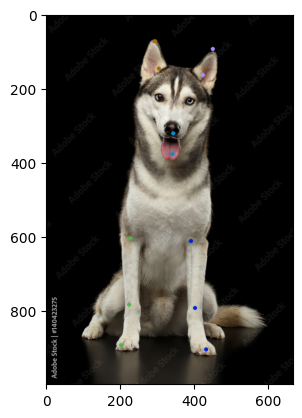

In [18]:
prepare_predictions('', 'input/dog2.jpg', model)

# video work

In [35]:
def prepare_video_predictions(video_path, model, output_path='/content/drive/MyDrive/APE/proj1/results/trim2.avi', BOX_IOU_THRESH=0.55, BOX_CONF_THRESH=0.30, KPT_CONF_THRESH=0.68):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make predictions
        results = model(frame_rgb, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

        if not len(results.boxes.xyxy):
          return frame_rgb

        # Get the predicted boxes, conf scores, and keypoints.
        pred_boxes = results.boxes.xyxy.numpy()
        pred_box_conf = results.boxes.conf.numpy()
        pred_kpts_xy = results.keypoints.xy.numpy()
        pred_kpts_conf = results.keypoints.conf.numpy()




        # Draw predicted bounding boxes, conf scores, and keypoints on image.
        for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
            kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
            filter_kpts = kpts[kpts_ids]
            filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
            frame = draw_boxes(frame, boxes, score=score)
            
            frame = draw_landmarks(frame, filter_kpts)

        # Save the frame to the output video
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return output_path


In [36]:
prepare_video_predictions('/content/drive/MyDrive/APE/proj1/video_data/trim2.mp4',   model)

'/content/drive/MyDrive/APE/proj1/results/trim2.avi'

In [ ]:
import os

In [ ]:
len(os.listdir('/content/drive/MyDrive/APE/proj1/Images'))

120